# VOCODER ANALYSIS

## Authors:
* Cortada Garcia, Martí
* Gadea Alcaide, Tomás
* Matas Albiol, Pau
* Poch Soler, Jofre

### Setup:

In [1]:
# numerical
import scipy.io
import scipy.signal
from scipy.signal import convolve, correlate, argrelextrema
import numpy as np
# plotting
import matplotlib.pyplot as plt
%matplotlib notebook
# sound modules
import sounddevice as sd
from scipy.io import wavfile
# warnings
import warnings
warnings.filterwarnings('ignore')  # shut warnings

### Loading files:

In [2]:
mat = scipy.io.loadmat('sintesis.mat')  # dict
# delete useless data
del mat['__header__']
del mat['__version__']
del mat['__globals__']
print(mat.keys())

dict_keys(['coef', 'excit', 'ganancia'])


In [3]:
B = mat['ganancia'][0]
a_i = mat['coef']
x_n = mat['excit']

print("B   (type, shape) = ", type(B), B.shape)
print("a_i (type, shape) = ", type(a_i), a_i.shape)
print("x_n (type, shape) = ", type(x_n), x_n.shape)

B   (type, shape) =  <class 'numpy.ndarray'> (401,)
a_i (type, shape) =  <class 'numpy.ndarray'> (401, 11)
x_n (type, shape) =  <class 'numpy.ndarray'> (401, 120)


### Brief introduction:

Before getting into the subject, let us explain briefly how the synthetic signal is generated and how we will us it. The signal is generated as follows:
$$y[n]=bx[n]-\sum_{i=1}^{p}a_iy[n-1]\hspace{1cm}n=0,...,N-1$$
where:
* $b=$ gain 
* $x[n]=$ excitation ($x[n]=excit[n]$)
* $coef[i]=a[i];$   $i=0,...,p;$   $a[0=1]$

and we keep concatenating each $y[n]$ frame till we get the total synthetic signal. Once understood the mathematical aprroximation, we will take advantadge of $\texttt{python}$ and use **scipy.signal.lfilter(** _b, a, x, axis=- 1, zi=None_ **)** which modelizes the previous approximation directly.

# SECTION A: Filtering 

## Question a)

We are asked to represent the impulse response of the 100th frame. To do so, we will put at the input of the filter the sequence $x[n]={1, 0, 0, 0, 0, ...}$ Afterwards, we will study its lenght:

<StemContainer object of 3 artists>

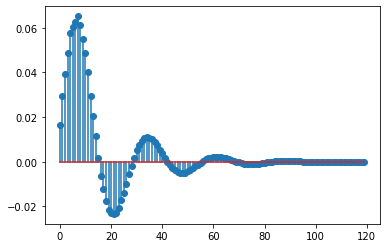

In [4]:
dK = np.array([1]+[0]*119)  # Kronecker delta
h_n = scipy.signal.lfilter([B[99]], a_i[99], dK, axis= -1, zi=None)  # impulse response 
plt.close('all')
plt.stem(range(120), h_n)

In [5]:
print(len(h_n))

120


### Conclusion Question a)
The impulse response has length 120.

## Question b)

We will represent the same output (that is the 100th frame), but now we are asked to apply its corresponding excitement and gainth (that we can find at _sintesis.mat_ file, which we previously load). Let's see the output:

<StemContainer object of 3 artists>

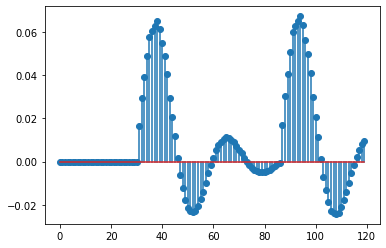

In [6]:
y_n = scipy.signal.lfilter([B[99]], a_i[99], x_n[99], axis= -1, zi=None)
plt.close('all')
plt.stem(range(120), y_n)

## Question c)

Finally, we will compute the total synthesis filtring all frames with its corresponding excitations and concatenating the outputs. Let's check what happens:

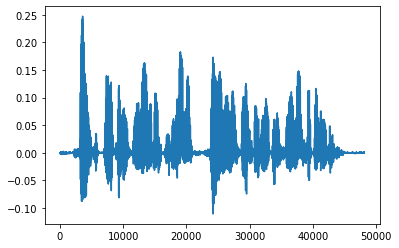

In [7]:
domain = range(120*401)
output = np.array([])
for n in range(401):
    output = np.append(output, scipy.signal.lfilter([B[n]], a_i[n], x_n[n], axis= -1, zi=None))

plt.close('all')
plt.plot(domain, output)

In [8]:
sd.play(output)
output = output.astype(np.float32)
scipy.io.wavfile.write('c_rapido.wav', rate=48000, data=output)

The output signal is quite short to be heard propperly, thus let output be rescaled for the sake of practicality:

In [9]:
def rescale(signal, factor=6, interpolate=False):
    dom = signal.size
    if not interpolate:
        new = np.zeros(dom*factor)
        for idx, val in enumerate(signal):
            new[idx*factor] = val
        return new
    # with interpolation:
    return np.interp(np.linspace(0, dom, factor*dom+1), np.arange(dom), signal)

In [10]:
output_r = rescale(output)
sd.play(output_r)
output_r = output_r.astype(np.float32)
scipy.io.wavfile.write('c.wav', rate=48000, data=output_r)

## Question d)

In [11]:
idxs = np.argwhere(output==0)
print("There are ", len(idxs), " points where output is zero.")
first_zero =  idxs[0,0]
print("The first index where output is zero: ", first_zero)

There are  4927  points where output is zero.
The first index where output is zero:  3360


In order to find out how many points of the signal have the value 0, we have used the command ```idxs = np.argwhere(output==0)```. It clearly shows that there are 4927 points where the output signal is 0.

Once having shown that, the next step is showing that there are some segments where the synthesized signal changes abruptly to 0 and other short ones which also take the value 0. To see that, we have projected a short segment (lenght 30) of the output signal that contains some 0 values:

<StemContainer object of 3 artists>

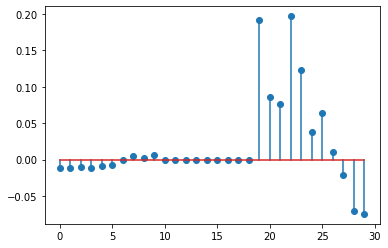

In [12]:
plt.close('all')
plt.stem(range(30), output[first_zero - 10:first_zero+20])

### Conclusion Question d)
In this example we can see that there is a secuence where the output is zero, and suddenly it changes to a higher value. If we repeat this for every zero secuence, we can see the changes on the signal.

## Question e)

To synthesize all the frames so that the output signal doesen't present the value 0 at any point, it is necessary a loop that, for each individual frame, its initial conditions ```zi``` are the final conditions ```zf```of the previous frame (setting the initial conditions of the first frame as an array of zeros).

In [13]:
output2 = np.array([])
zf = np.zeros(10)
for n in range(401):
    evaluate, zf = scipy.signal.lfilter([B[n]], a_i[n], x_n[n], axis= -1, zi=zf)
    output2 = np.append(output2, evaluate)

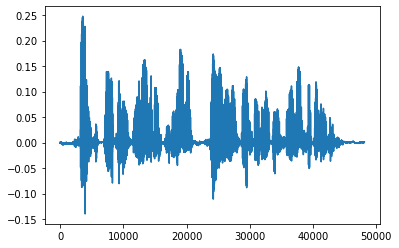

In [14]:
plt.close('all')
plt.plot(range(120*401), output2)

In [15]:
idxs = np.argwhere(output2==0)
print(len(idxs))

0


### Conclusion Question e)
It is shown by the last cell of code that there are 0 indexes where the output signal is zero.

## Question f)

Again, let output2 be rescaled:

In [16]:
output2_r = rescale(output2, interpolate=True)

In [17]:
sd.play(output_r)

In [18]:
sd.play(output2_r)
output2_r = output2_r.astype(np.float32)
scipy.io.wavfile.write('f.wav', rate=48000, data=output2_r)

### Conclusion Question f)
The first signal is of a such lower quality than the second one. This is because the output2 signal has been fedback with itself, and the union of the phonemes is smoother. Therefore, it sounds more clear.

# SECTION B: Excitation estimation

## Question a)

We know that the correlation of a signal tries to find the resemblance between this signal and itself shifted. Now we suppose we have a $f[n]$. Let us define its autocorrelation as $R_{ff}[n]$. Now, let's define the signal $s[n] = f[n] +f[n‐N]+f[n‐2N]$. We will demonstrate that its autocorrelation is $R_{ss}[m]= 3R_{ff}[m]+2R_{ff}[m ‐N]+2R_{ff}[m +N]+ R_{ff}[m ‐2N]+ R_{ff}[m +2N]$.
First of all, we should remember some theoretical concepts:
###### Definition of autocorrelation: 
$$R_{ss}[m]=\sum_{n=-\infty}^{\infty}s[n+m]s^*[n]=\sum_{n=-\infty}^{\infty}s[n]s^*[n-m]$$
###### Important to take into account:
We will perform many **change of variables** and we would like to recall that we are talking about "_variables mudas_ ", so, it does not affect on the definition of autocorrelation. 

$$\begin{align}
R_{ss}[m]&=\sum_{n=-\infty}^{\infty}s[n+m]s^*[n]=\sum_{n=-\infty}^{\infty}s[n]s^*[n-m]=\{{\text{by definition of }s[n]}\}\\
         &=\sum_{n=-\infty}^{\infty}\{\{f[n+m]+f[n+m-N]+f[n+m-2N]\}·\{f^*[n]+f^*[n-N]+f^*[n-2N]\}\}
\end{align}$$

where we will perform all different products (recalling what we said about the change of variables):

* $\sum_{n=-\infty}^{\infty}f[n+m]f^*[n]=R_{ff}[m]$
* $\sum_{n=-\infty}^{\infty}f[n+m]f^*[n-N]=\{\text{let }k=n-N\}=\sum_{k=-\infty}^{\infty}f[k+N+m]f^*[k]=R_{ff}[m+N]$
* $\sum_{n=-\infty}^{\infty}f[n+m]f^*[n-2N]=\{\text{let }k=n-2N\}=\sum_{k=-\infty}^{\infty}f[k+2N+m]f^*[k]=R_{ff}[m+2N]$
* $\sum_{n=-\infty}^{\infty}f[n+m-N]f^*[n]=R_{ff}[m-N]$
* $\sum_{n=-\infty}^{\infty}f[n+m-N]f^*[n-N]=\{\text{let }k=n-N\}=\sum_{k=-\infty}^{\infty}f[k+m]f^*[k]=R_{ff}[m]$
* $\sum_{n=-\infty}^{\infty}f[n+m-N]f^*[n-2N]=\{\text{let }k=n-2N\}=\sum_{k=-\infty}^{\infty}f[k+N+m]f^*[k]=R_{ff}[m+N]$
* $\sum_{n=-\infty}^{\infty}f[n+m-2N]f^*[n]=R_{ff}[m-2N]$
* $\sum_{n=-\infty}^{\infty}f[n+m-2N]f^*[n-N]=\{\text{let }k=n-N\}=\sum_{k=-\infty}^{\infty}f[k-N+m]f^*[k]=R_{ff}[m-N]$
* $\sum_{n=-\infty}^{\infty}f[n+m-2N]f^*[n-2N]=\{\text{let }k=n-2N\}=\sum_{k=-\infty}^{\infty}f[k+m]f^*[k]=R_{ff}[m]$

and adding all the past results we obtain:

$$R_{ss}[m]= 3R_{ff}[m]+2R_{ff}[m‐N]+2R_{ff}[m+N]+ R_{ff}[m‐2N]+ R_{ff}[m+2N]$$

$$\quad Q.E.D.$$

## Question b)

<StemContainer object of 3 artists>

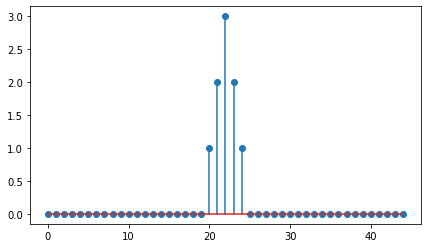

In [19]:
f = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Rff = correlate(f, f, 'full')
plt.close('all')
plt.figure(figsize=(7,4))
plt.stem(range(len(Rff)), Rff)

<StemContainer object of 3 artists>

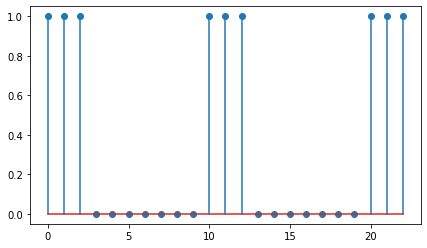

In [20]:
# n=10
f =    np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
f_N =  np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
f_2N = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

s = f + f_N + f_2N

plt.close('all')
plt.figure(figsize=(7,4))
plt.stem(range(len(s)), s)

<StemContainer object of 3 artists>

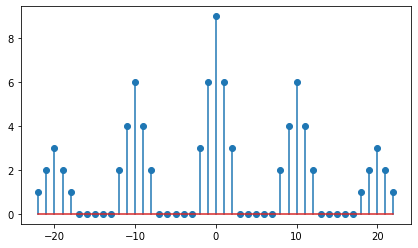

In [21]:
Rss = correlate(s, s, 'full')
plt.close('all')
plt.figure(figsize=(7,4))
plt.stem(range(-len(Rss)//2 + 1, len(Rss)//2 + 1), Rss)

### Conclusion Question b)
With this example we have built it looks clear that this phenomenon certainly happens. If we plot the autocorrelation centered at 0, with a period $N = 10$ we see relative maximums at $\;\pm N = \pm 10\;$ and $\;\pm 2N = \pm 20$.

## Question c)

We have chosen $0$ to be the _null_ value for the period. Signals that have the value $0$ as period are the ones that are considered _non-periodic_.

In [22]:
def is_noise(origin, N, Rxx):
    return (Rxx[origin + N] / Rxx[origin]) < 0.4

In [23]:
def period(x):
    Rxx = correlate(x, x, 'full')
    origin = np.argmax(Rxx)
    idxs = argrelextrema(Rxx[origin:], np.greater)[0]
    if idxs.size == 0:
        return 0 # null
    N = idxs[np.argmax([Rxx[origin+idx] for idx in idxs])]  # period

    if is_noise(origin, N, Rxx):
        return 0
        
    return N

In [24]:
periods = np.array([]).astype(int)
for n in range(401):
    signal = x_n[n]
    if not(period(signal)):
        periods = np.append(periods, 0)
    else:
        periods = np.append(periods, period(signal))

print(periods)


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 43 43 44 45 47 49 51 54 56 59 61 62 63  0  0  0  0  0  0  0 45
  0  0  0  0  0  0  0  0  0  0  0 62 54 49 49 50 51 59 48 51 53 59  0  0
  0  0  0  0 57 59 61 62 62 64 65  0 66 66 65 64 64  0  0  0  0  0  0  0
  0 55 55 56 56 57 57 57 57 54 54 53 51 54 54 55 55 55 55 56 49 59 59 59
 62  0  0  0  0 61 63 65 66  0  0  0  0  0  0  0  0  0  0  0  0 53 56  0
  0  0  0  0 59 60 61 61 60 58 57 58 57 57 56 55 54 53 52 49 48 46 44 43
 43 43 43 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 46 44 43 43 43 43 43 43 44 42 42 42 43 43 43 43 43
 44 45 46 47 48 49 49 49 50 50 52 53 53 52 53 56  0  0  0  0  0  0  0 45
 50 51 52 51 50 50 50 48 48 52  0  0  0  0  0  0 44 44 43 44 46 66  0  0
  0 49 49 50 51 53 53 54 55 55 56 57  0  0  0  0  0 27 27  0  0 44 44 45
 47  0  0  0  0  0  0  0  0  0 45 46 47 48 52 53 55 56 56 57 56 55 55 54
 55 55 54 51 49 48 50  0  0  0  0  0  0  0 34 52 53

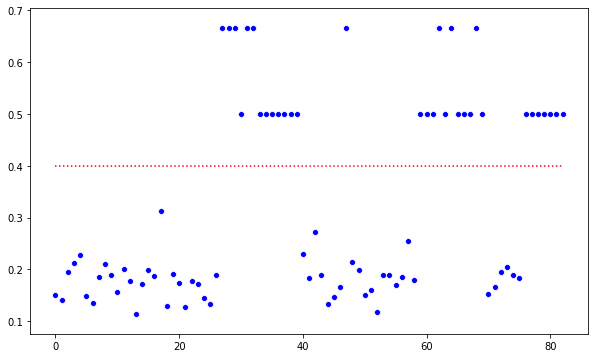

In [25]:
arr = np.array([])
for i in range(401):
    Rxx = correlate(x_n[i], x_n[i], 'full')
    origin = np.argmax(Rxx)
    idxs = argrelextrema(Rxx[origin:], np.greater)[0]
    if idxs.size == 0:
        break
    N = idxs[np.argmax([Rxx[origin+idx] for idx in idxs])]  # period
    arr = np.append(arr, Rxx[origin + N] / Rxx[origin])

import seaborn as sns
line = [0.4 for _ in range(arr.size)]
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(arr)), y=arr, color='b')
plt.plot(line, color='r', ls=':')

## Question d)

In [26]:
def noise_generator(len):
    return np.random.normal(loc=0, scale=1, size=len)

In [27]:
def deltas(start, Ni):
    x = np.zeros(120)
    i = 0
    while (start + i) < 120:
        x[int(start+i)] = 1
        i = i + Ni
    return x, 120 - (start + i - Ni)

In [28]:
def generate_X(p):
    X=np.zeros((401, 120))
    D = np.zeros(401)
    
    diff = 0
    for i in range(401):
        Ni = p[i]
        if Ni != 0:
            if diff != 0:
                start = Ni - diff
            else:
                start = 0
            while start < 0:
                start = start + Ni
            x, diff = deltas(start, Ni)
            X[i] = np.array([x])
            D[i] = diff
        else:
            X[i] = np.array([noise_generator(120)])
            D[i] = diff
    return X, D

In [29]:
excit, diffs = generate_X(periods)  # array with the excitation sequences

Let us show an example of the two different types of excitations:

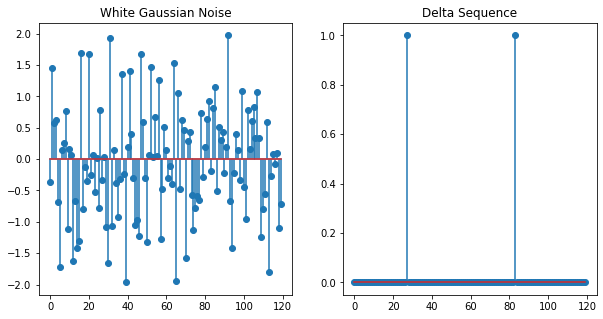

In [30]:
noise_example = excit[0]
periodic_signal_example = excit[99]

fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(10)
axs[0].stem(noise_example)
axs[0].title.set_text('White Gaussian Noise')
axs[1].stem(periodic_signal_example)
axs[1].title.set_text('Delta Sequence')
plt.show()

One of them is the noisy one, used for obstruent phonemes and the other one is an example of a sequence of deltas, used for sonorant phonemes.

## Question e)

In [31]:
audio = np.array([])
zf = np.zeros(10)
for n in range(401):
    evaluate, zf = scipy.signal.lfilter([B[n]], a_i[n], excit[n], axis= -1, zi=zf[-10:])
    audio = np.append(audio, evaluate)

In [32]:
audio_r = rescale(audio, interpolate=True)
sd.play(audio_r)
audio_r = audio_r.astype(np.float32)
scipy.io.wavfile.write('excit.wav', rate=48000, data=audio_r)

The sequence is heard properly. However, there are some loud short bumbs in the signal. This could be caused because of some kind of delay between the original excitations and the ones generated here.

Below, we have an axample of sequence of given excitation sequences and the ones generated by us. We can see there is a little delay between the given ones and the ones generated here, and this could be the reason of the bumps in the audio.

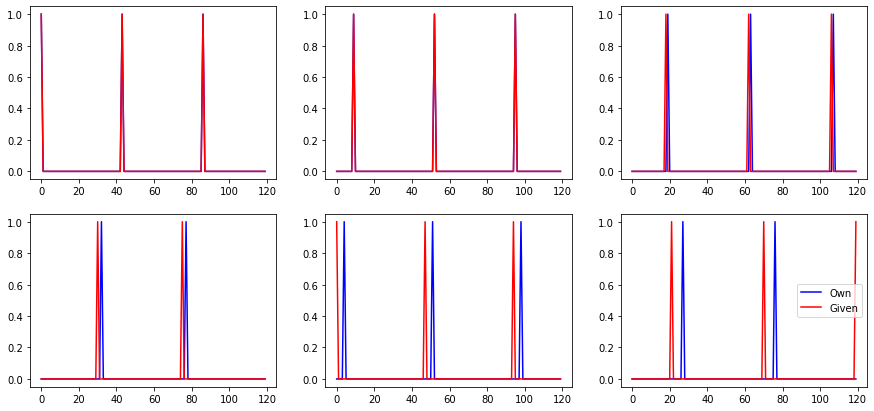

In [33]:
n = 27

ex = [excit[i] for i in range(n, n+6)]
x  = [x_n[i] for i in range(n, n+6)]

fig = plt.figure(figsize=(15, 7))
for i in range(6):
    ax = fig.add_subplot(2,3,i+1);
    ax.plot(ex[i], color='b', label='Own')
    ax.plot(x[i], color='r', label='Given')

plt.legend()
plt.show()

To make sure the delay is not an error of our functions, let's check the deltas in the given set x_n follow the rule stated in the PDF: **the first delta of the
n-th frame does not have to start at n = 0 but must start at position Ni-number of
samples between the last delta and NT.**

First, we check the periods are the equal for x_n and our excitations:

In [34]:
xnperiods = np.zeros(401)

for n in range(401):
    if periods[n] != 0:
        ones = np.argwhere(x_n[n] != 0.0)
        xnperiods[n] = abs(ones[0] - ones[1])
        
    else:
        xnperiods[n] = 0

np.count_nonzero(xnperiods == periods) # All the 401 periods are equal

401

Now let's check the differences we used to shift the first delta in our excitations are not all the same that the ones extracted through x_n:

In [35]:
xndiffs = np.zeros(401)

for n in range(401):
    if xnperiods[n] != 0:
        ones = np.argwhere(x_n[n] != 0.0)
        last = ones[-1]
        xndiffs[n] = 120 - last
    else:
        xndiffs[n] = xndiffs[n-1]

np.count_nonzero(xndiffs == diffs) # only 31 of 401 diffs are the same

31

Finally, let's check that not all the differences computed through x_n follow the rule stated in the PDF:

In [36]:
correct_diff = np.ones(401, dtype=bool)

for n in range(401):
    if xnperiods[n] != 0:
        ones = np.argwhere(x_n[n] != 0.0)
        first = ones[0]
        if first != xnperiods[n] - xndiffs[n-1]:
            correct_diff[n] = False

np.count_nonzero(correct_diff) # only 254 diffs are following the rule

254

Therefore, we can conclude that the delays are not due to a bug in the code nor to a theoretical implementation mistake. The delay is intrinsic in the way the rule for the shifting of the first deltas has been stated. So the bumps in the audio cannot be removed with the current information.

## Question f)

In [37]:
var = [0.5, 3, 0.2, 0.01] #variations of the period
    
new_p = [(periods.copy() * v).astype(int) for v in var] # new periods

excits = [generate_X(p)[0] for p in new_p]

audios = [0, 0, 0, 0]
audio2 = np.array([])
zf = np.zeros(10)

for i in range(len(var)):
    audios[i] = np.array([])
    for n in range(401):
        evaluate, zf = scipy.signal.lfilter([B[n]], a_i[n], excits[i][n], axis= -1, zi=zf[-10:])
        audios[i] = np.append(audios[i], evaluate)
    
    audios[i] = rescale(audios[i], interpolate=True)
    audios[i] = audios[i].astype(np.float32)
    scipy.io.wavfile.write('last{}.wav'.format(i), rate=48000, data=audios[i])

import time
for aud in audios:
    sd.play(aud)
    time.sleep(7)

In the first example, the period of every frame is decremented by a 50% of its value. Consequently, when the resultant synthesized signal is reproduced, we can observe a clear change. The decrementation of the period produces the signal's sound sharper when it is reproduced. We have increased the pitch!

The same occurs for all the examples. If the variation is greater than 1, the signal sounds graver. However, the last variation (0.01) sounds graver. This is not actually true, the thing is that the pitch is so sharp human ear cannot even hear it. And we only hear the grave distorsioned part.